In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
!wget https://docs.opencv.org/4.x/lena.png

#object detection
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/arunponnusamy/object-detection-opencv/master/yolov3.cfg
!wget https://raw.githubusercontent.com/arunponnusamy/object-detection-opencv/master/yolov3.txt
!wget https://s0.geograph.org.uk/geophotos/03/29/42/3294224_285a09fa.jpg -O city.jpg

--2023-06-17 21:06:31--  https://docs.opencv.org/4.x/lena.png
Resolving docs.opencv.org (docs.opencv.org)... 172.67.218.21, 104.21.24.86, 2606:4700:3034::ac43:da15, ...
Connecting to docs.opencv.org (docs.opencv.org)|172.67.218.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 620636 (606K) [image/png]
Saving to: ‘lena.png.4’

lena.png.4          100%[===================>] 606.09K  --.-KB/s    in 0.05s   

2023-06-17 21:06:31 (11.8 MB/s) - ‘lena.png.4’ saved [620636/620636]

--2023-06-17 21:06:31--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  40.4MB/s    in 6.3s    

2023-06-17 21:06:38 (37.8 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

-

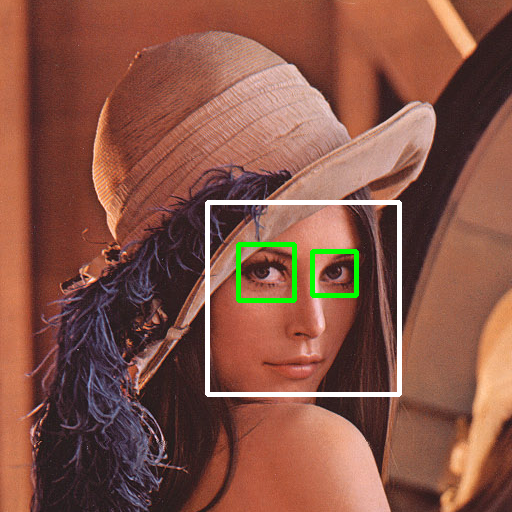

In [ ]:
def faceDetection(image):

  face_color=(255,255,255)
  eyes_color=(0,255,0)

  image = cv2.imread(image)

  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+"haarcascade_frontalface_default.xml")
  eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+"haarcascade_eye.xml")

  faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)

  for (x,y,w,h) in faces:
          cv2.rectangle(image,(x,y),(x+w,y+h),face_color,3)

          gray_eye_reg = gray_image[y:y+h,x:x+w]
          image_eye_reg = image[y:y+h,x:x+w]

          eyes = eye_cascade.detectMultiScale(gray_eye_reg, 1.3, 5)

          for (ex,ey,ew,eh) in eyes:
                  cv2.rectangle(image_eye_reg,(ex,ey),(ex+ew,ey+eh),eyes_color,3)



  cv2_imshow(image)

faceDetection('lena.png')


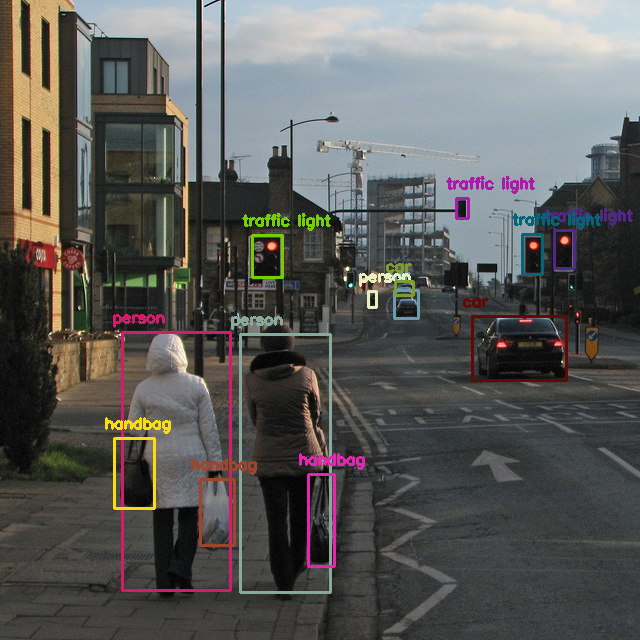

In [ ]:
def get_output_layers(net):

    layer_names = net.getLayerNames()
    try:
        output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    except:
        output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers


def draw_prediction(img, labels, label_id, confidence, x, y, x_plus_w, y_plus_h):

    COLORS = np.random.uniform(0, 255, size=(len(labels), 3))

    label = str(labels[label_id])

    color = COLORS[label_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


def objectDetect(image,config='yolov3.cfg',weights='yolov3.weights',classes='yolov3.txt'):

  image = cv2.imread(image)
  scale = 0.00392
  Width=image.shape[1]
  Height=image.shape[0]

  with open(classes) as cl:
    labels = [label.strip() for label in cl.readlines() ]

  net = cv2.dnn.readNet(weights, config)

  blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

  net.setInput(blob)

  outs = net.forward(get_output_layers(net))

  class_ids = []
  confidences = []
  boxes = []
  conf_threshold = 0.5
  nms_threshold = 0.4


  for out in outs:
      for detection in out:
          scores = detection[5:]
          class_id = np.argmax(scores)
          confidence = scores[class_id]
          if confidence > 0.5:
              center_x = int(detection[0] * Width)
              center_y = int(detection[1] * Height)
              w = int(detection[2] * Width)
              h = int(detection[3] * Height)
              x = center_x - w / 2
              y = center_y - h / 2
              class_ids.append(class_id)
              confidences.append(float(confidence))
              boxes.append([x, y, w, h])


  indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

  for i in indices:
      try:
          box = boxes[i]
      except:
          i = i[0]
          box = boxes[i]

      x = box[0]
      y = box[1]
      w = box[2]
      h = box[3]
      draw_prediction(image, labels, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

  cv2_imshow(image)


objectDetect('city.jpg')